In [1]:
%load_ext autoreload
%autoreload 2

# TUNED | RANDOM FOREST | ALL VARIABLES WITHOUT RESEARCH

### Is it still possible to predict which observations decrease $\alpha_R$ without the strongest influence of research variables?

In [2]:
import sys
sys.path.append('../../')
import tokamakTK


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support


pd.set_option('display.max_columns', None)
path = "../../data/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


Class distribution can be considered is skewed.

## Treatment to Categorical and Numerical Data

In [4]:
features = ['ZEFFNEO', 'EPS', 'WFICFORM', 'DWDIA', 'KAREA', 
            'OMEGACYCL', 'ENBI', 'WMHD', 'AMIN', 'WFFORM', 'PICRH', 'PLTH', 'MEFF', 
            'QCYL5', 'PNBI', 'VOL', 'LCOULOMB', 'LHTIME', 'PFLOSS', 'BEIMHD', 
            'POHM', 'ZEFF', 'PECRH', 'ELMFREQ', 'PRAD', 'NESOL', 'TORQ', 'TOK', 'WALMAT', 'DIVNAME', 
            'LIMMAT', 'HYBRID', 'EVAP', 'ECHMODE', 'PREMAG', 'DIVMAT', 'PELLET', 'ELMTYPE', 'AUXHEAT', 'CONFIG']


DB5 = tokamakTK.clean_categorical_data(DB5)


# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()


data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

data_num = tokamakTK.clean_numerical_data(data_num)

data_ = pd.concat([data_num,
                  (pd.concat([
                       DB5[["label"]], 
                       tokamakTK.encode_categorical_ohe(data_cat)
                      ], axis=1)
                  )],
                  axis=1)

In [5]:
X = data_.drop("label", axis=1)
y = data_["label"]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

In [6]:
# Define random forest classifier with preprocessor as a pipeline

rf = RandomForestClassifier(min_samples_split=2,
                            min_samples_leaf=1,
                            n_estimators = 200,
                            max_depth = 25,
                            criterion='entropy',
                            max_features=None,
                            random_state=71,
                            n_jobs=-1
                           )

rf.fit(X_train, y_train)
y_pred= rf.predict_proba(X_test)

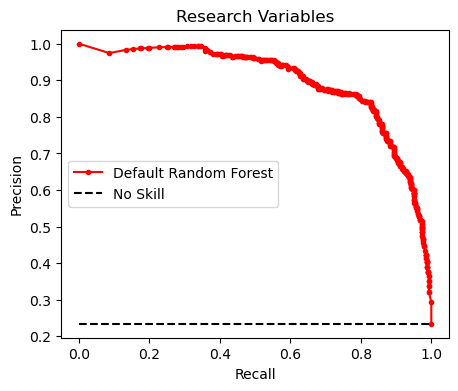

In [7]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall, precision, marker='.', label='Default Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Research Variables")
plt.legend();

In [8]:
y_pred_ = rf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

(array([0.8622449 , 0.93126685]),
 array([0.76818182, 0.96239554]),
 array([0.8125    , 0.94657534]),
 array([ 440, 1436]))

## [Feature Importance Based on Mean Decrease in Impurity](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

Feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

**WARNING**:  Impurity-based feature importances can be misleading for high cardinality features (many unique values). See Permutation feature importance.

In [9]:
importances = rf.feature_importances_

feature_importances = pd.DataFrame({"feature": X.columns, "importance": importances})
feature_importances = feature_importances.sort_values("importance", ascending=False).reset_index(drop=True)

print(feature_importances)

            feature  importance
0          LCOULOMB    0.146742
1             QCYL5    0.092925
2            LHTIME    0.091196
3              POHM    0.054552
4              WMHD    0.052751
..              ...         ...
133  PELLET_UNKNOWN    0.000000
134         TOK_PDX    0.000000
135  DIVMAT_UNKNOWN    0.000000
136       TOK_START    0.000000
137       DIVMAT_SS    0.000000

[138 rows x 2 columns]


In [10]:
df = pd.DataFrame(feature_importances)
df.feature.unique()

array(['LCOULOMB', 'QCYL5', 'LHTIME', 'POHM', 'WMHD', 'WFFORM',
       'OMEGACYCL', 'NESOL', 'AMIN', 'PFLOSS', 'BEIMHD', 'VOL', 'ENBI',
       'KAREA', 'PLTH', 'PRAD', 'ZEFF', 'EPS', 'PELLET_NONE', 'PNBI',
       'WFICFORM', 'DWDIA', 'HYBRID_YES', 'MEFF', 'CONFIG_SN(U)', 'TORQ',
       'ELMFREQ', 'EVAP_NONE', 'ZEFFNEO', 'HYBRID_UNKNOWN',
       'ECHMODE_NONE', 'PICRH', 'PELLET_GAS-FUEL', 'DIVNAME_RDP', 'PECRH',
       'PREMAG_UNKNOWN', 'PREMAG_YES', 'ELMTYPE_TYPE-I', 'CONFIG_SN(L)',
       'ELMTYPE_TYPE-III', 'CONFIG_SN', 'ELMTYPE_UNKNOWN', 'PELLET_D',
       'HYBRID_NO', 'WALMAT_IN', 'WALMAT_C-W', 'PREMAG_NO',
       'ECHMODE_UNKNOWN', 'AUXHEAT_NBIC', 'TOK_AUG', 'AUXHEAT_NB',
       'TOK_D3D', 'DIVMAT_C/BE', 'WALMAT_C', 'EVAP_SILICON',
       'DIVNAME_MARK', 'CONFIG_DN', 'ELMTYPE_TYPE-II', 'EVAP_BO',
       'DIVNAME_MARKSR', 'DIVMAT_C', 'WALMAT_W', 'LIMMAT_C',
       'DIVNAME_DV-II', 'DIVMAT_W', 'ELMTYPE_TYPE-V', 'LIMMAT_BE',
       'EVAP_BE', 'AUXHEAT_NBEC', 'WALMAT_IN/C', 'ELMTYPE_T

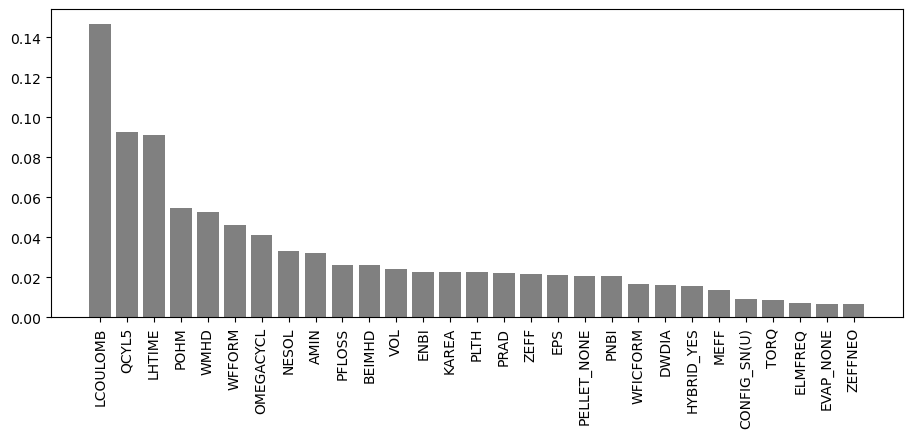

In [11]:
plt.figure(figsize=(11,4))
plt.bar(df[df.importance > 0.5e-2].feature, df[df.importance > 0.5e-2].importance, color="gray")
plt.xticks(rotation=90);

In [12]:
# Quite Important
df[df.importance > 0.005].feature.values

array(['LCOULOMB', 'QCYL5', 'LHTIME', 'POHM', 'WMHD', 'WFFORM',
       'OMEGACYCL', 'NESOL', 'AMIN', 'PFLOSS', 'BEIMHD', 'VOL', 'ENBI',
       'KAREA', 'PLTH', 'PRAD', 'ZEFF', 'EPS', 'PELLET_NONE', 'PNBI',
       'WFICFORM', 'DWDIA', 'HYBRID_YES', 'MEFF', 'CONFIG_SN(U)', 'TORQ',
       'ELMFREQ', 'EVAP_NONE', 'ZEFFNEO'], dtype=object)

In [13]:
# Not so important
df[df.importance < 1e-3]

,feature,importance
46,PREMAG_NO,0.000942
47,ECHMODE_UNKNOWN,0.000886
48,AUXHEAT_NBIC,0.000883
49,TOK_AUG,0.000868
50,AUXHEAT_NB,0.000867
...,...,...
133,PELLET_UNKNOWN,0.000000
134,TOK_PDX,0.000000
135,DIVMAT_UNKNOWN,0.000000
136,TOK_START,0.000000


In [15]:
df[df.importance == 0]

,feature,importance
108,CONFIG_DND,0.0
109,EVAP_DECABOA,0.0
110,EVAP_C-H,0.0
111,EVAP_C,0.0
112,AUXHEAT_UNKNOWN,0.0
113,CONFIG_BOT,0.0
114,TOK_TDEV,0.0
115,DIVNAME_DIV1,0.0
116,CONFIG_LIM,0.0
117,CONFIG_MAR,0.0
